<a href="https://colab.research.google.com/github/JinnieL/Sentiment_Analysis/blob/main/KoBERT_%ED%99%98%EA%B2%BD_%EC%84%A4%EC%A0%95_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python 3.7.0 버전 설치

In [1]:
# # 2024/09/04 파이썬 버전 변경
# ! python --version        # 버전 확인

In [2]:
# !sudo apt upgrade
# !sudo apt install python3.7

In [3]:
# ! python --version

In [4]:
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1

In [5]:
# !sudo update-alternatives --config python3

In [6]:
# !python --version
# !pip --version

In [7]:
# pip 설치
# !sudo apt install python3-pip

In [8]:
# !python --version
# !pip --version

In [9]:
# # ModuleNotFoundError 해결 - distutils.util 설치
# !sudo apt install python3.7-distutils

In [10]:
# !python --version
# !pip --version

# 한글 깨짐 방지 설정

In [11]:
# 한글 깨짐을 방지한 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [12]:
# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# Colab 환경 세팅

In [13]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

# KoBERT 모델을 Colab에 설치하기

In [14]:
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master        # onnxruntime version error
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
# !pip install onnxruntime

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-b4n6nccx/kobert-tokenizer_82be6475884e4950a87153a61becd024
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-b4n6nccx/kobert-tokenizer_82be6475884e4950a87153a61becd024
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [15]:
# koBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# Transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [16]:
!pip install numpy==1.23.1

In [17]:
# Setting Library
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [18]:
import numpy as np
import pandas as pd

# Colab GPU 활용
device = torch.device("cuda:0")

# Data Concatenation

In [19]:
conv_df = pd.read_excel("/content/Data/감성대화말뭉치(최종데이터)_Training.xlsx")
conv_df.head(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,4,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,5,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN
5,6,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.,진로에 대해서 고민하고 계시는군요. 어떤 점이 고민인가요?,직장 상사한테 자주 지적을 받아. 그럴 때마다 이 업무는 나랑 맞지 않는 거 같이 ...,업무가 나와 맞지 않아 시간을 버리는 것 같이 느껴지셨군요.,NaN,NaN
6,7,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.,부모님의 노여움에 섭섭하시군요. 이런 상황을 어떻게 해결하면 좋을까요?,부모님께 좀 더 시간을 달라고 해야겠어. 진로 테스트를 받아볼까 생각 중이야.,진로 테스트를 받아보겠다고 부모님께 말씀드릴 생각이군요.,NaN,NaN
7,8,청년,여성,"진로,취업,직장",해당없음,기쁨,느긋,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,천천히라도 직장을 구해 보려고 하시는군요. 특별한 이유가 있으신가요?,더 좋은 회사가 기다리고 있을지도 모르는데 쉬고 있기가 좀 그래.,좋은 일자리를 놓치고 싶지 않아 끊임없이 노력하시는군요. 하는 일이 잘 풀리시길 바라요.,NaN,NaN
8,9,청년,여성,"진로,취업,직장",해당없음,불안,걱정스러운,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.,취업에 대해 걱정이 되는군요.,응. 느긋함을 느끼는 내가 좀 싫었는데 걱정을 많이 하는 것보다는 낫다는 생각도 들어.,걱정보다는 느긋한 태도가 낫다고 생각하시는군요.,NaN,NaN
9,10,청년,여성,"진로,취업,직장",해당없음,기쁨,느긋,요즘 직장생활이 너무 편하고 좋은 것 같아!,직장생활이 편하고 좋으시다니 좋아 보여요. 다니고 계신 회사만의 장점이 있나요?,우리 회사는 복지가 정말 좋아! 내가 곧 출산하게 되는데 육아휴직 기간도 긴 데다가...,예비 엄마들에게는 정말 꿈의 회사인 것 같네요. 마음이 편하시겠어요.,NaN,NaN


In [20]:
print(conv_df.shape)
print(conv_df.isnull().sum())

(51630, 13)
Unnamed: 0       0
연령               0
성별               0
상황키워드            0
신체질환             0
감정_대분류           0
감정_소분류           0
사람문장1            0
시스템문장1           0
사람문장2            0
시스템문장2           0
사람문장3         8935
시스템문장3        8935
dtype: int64


In [21]:
conv_val_df = pd.read_excel("/content/Data/감성대화말뭉치(최종데이터)_Validation.xlsx")
conv_val_df.sample(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
6142,6143,중년,여성,"직장, 업무 스트레스",해당없음,슬픔,염세적인,나는 열심히 일해도 보람이 없어 나는 되는 일이 없어,무슨 일이세요?,열심히 고민하고 나름대로 생각해서 작성했던 기획안이 또 탈락했어.,열심히 작성하신 기획안이 탈락하셨군요.,NaN,NaN
1449,1450,중년,여성,"직장, 업무 스트레스",해당없음,상처,희생된,회사에서 아무도 안 가겠다고 해서 어쩔 수 없이 내가 출장을 가야 했어. 너무 스트...,장거리 출장을 모두 마다한 직장동료들 때문에 사용자님이 억지로 출장을 가게 됐군요.,다들 왜 이렇게 이기적인 건지 모르겠어. 어떻게 하면 그 사람들 약 올릴 수 있을까?,이기적인 동료들에게 어떻게 대응하고 싶으세요?,그 사람들과 똑같이 이기적으로 굴지 말고 출장을 잘 다녀와서 좋은 성과를 올리는 게...,출장에서 좋은 성과를 올리셔서 직장 동료분들이 부러워하시길 바랄게요.
4748,4749,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,그래요. 앞으로의 삶도 응원하고 있을게요.,NaN,NaN
2316,2317,청소년,여성,학업 및 진로,해당없음,당황,죄책감의,친한 친구의 비밀을 다른 친구에게 말해버렸어. 미안해서 어떻게 하지?,친구의 비밀을 말해서 미안한 감정이 드시겠어요.,절대 말하지 말라고 했는데 얼떨결에 내가 말해버렸어.,너무 당황스러우시겠어요. 어떻게 해결하는 게 좋을까요?,친구에게 사실대로 말하고 미안하다고 해야겠어.,친구에게 사과해서 잘 풀리길 바라요.
888,889,청년,여성,"연애,결혼,출산",해당없음,당황,당황,친구로만 생각했던 사람이 고백을 하니까 굉장히 당황스러워.,고백을 받아서 매우 당황스럽겠어요.,한 번도 이성으로 생각한 적이 없는데 갑자기 그러니 어쩔 줄을 모르겠어.,어떻게 하면 그 기분에서 나아질 수 있을까요?,모르겠어. 그 사람이랑 정말 어색해질 것 같은데 의논할 사람이 없네.,주변에 조언을 구할 만한 사람이 있으면 좋겠어요.
1226,1227,노년,여성,대인관계,만성질환 무,상처,괴로워하는,금자 할머니는 뭔가 큰 오해를 하고 나랑 말도 안 하려고 해서 고민이야.,오해하고 말을 하지 않으려는 금자 할머니 때문에 고민이시군요.,내가 아니라 옆집 할머니가 잘못한 일인데 내 잘못이라고 오해하는 것 같아.,예전에 내 잘못이라고 오해받았을 때는 어떻게 하셨나요?,그때는 내 잘못이 아니라고 당당하게 말했어. 이번에도 당당하게 이야기를 해봐야겠어.,서로 이야기를 나누고 잘 해결되었으면 좋겠어요.
2826,2827,노년,여성,대인관계,만성질환 무,상처,버려진,사람들과 어울리기 좋아했던 내가 이제는 찾아주는 사람이 없다는 게 너무 슬퍼.,혼자라는 생각에 정말 외로울 것 같아요.,나이를 먹으면서 더 외로움을 느끼는 것 같아. 더 이상 쓸모없는 사람이 된 것 같기...,외롭고 쓸쓸하다는 생각을 바꿀 수 있을 만한 방법이 뭐가 있을까요?,내가 먼저 찾아가거나 연락해보든가 해야지. 계속 이렇게 지낼 수만은 없으니까.,먼저 연락을 취해보려고 하시는군요.
1439,1440,중년,남성,"재정,은퇴,노후준비",해당없음,분노,짜증내는,우리 자녀들은 내가 은퇴하면 재정 지원을 안 해줄 거 같아서 짜증 나.,자녀분들이 어느 정도의 재정 지원도 안 해주면 엄청 짜증 나시겠어요.,은퇴를 하면 자녀들이 다 해줄 거 같더니.,자녀들이 재정 지원해줄 생각이 없어 보이면 어떻게 해야 할까요?,자녀들에게 한번 물어봐야겠어. 재정 지원을 해준다고 할지도 몰라.,자녀분들이 꼭 지원을 해주시고 더 돈독한 가족관계가 되셨으면 좋겠어요.
3712,3713,청년,여성,대인관계,해당없음,당황,외로운,내가 어릴 때 아빠가 돌아가셔서 엄마가 생활전선에 뛰어드셨어. 그런데 요즘 엄마의 ...,어머니 혼자 생계를 꾸려나는 모습이 외로워 보여 걱정되셨군요.,맞아 외로우실 어머니가 너무 걱정돼. 힘든 내색 하나 하지 않으시니 속을 알 수가 없어.,내색하지 않으셔서 얼마나 힘드실지 알 수 없는 마음에 더욱 걱정되시는군요. 이런 상...,빨리 직장인이 되어 엄마를 기쁘게 해드리고 싶어.,빨리 직장을 가져 어머니의 짐을 덜어드리고 싶으시군요.
128,129,청년,남성,"진로,취업,직장",해당없음,기쁨,감사하는,팀원들 덕분에 우리 프로젝트가 성공적으로 마무리 됐어. 미칠 듯이 기쁘다.,프로젝트가 성공적으로 끝나 기쁘시군요.,팀원들의 열정에 박수를 보내고 싶어.,어떻게 하면 더 발전할 수 있을까요?,이미 계획된 대로 유튜브를 통해 다시 한 번 전진할 거야.,준비하고 있는 계획이 있으시군요. 좋은 결과가 있기를 바라요.


In [22]:
print(conv_val_df.shape)
print(conv_val_df.isnull().sum())

(6641, 13)
Unnamed: 0       0
연령               0
성별               0
상황키워드            0
신체질환             0
감정_대분류           0
감정_소분류           0
사람문장1            0
시스템문장1           0
사람문장2            0
시스템문장2           0
사람문장3         1955
시스템문장3        1955
dtype: int64


감성대화말뭉치 train & validation data set과 단발성 데이터 셋을 모두 합친 뒤 train, validation, test 데이터 비율을 6 : 2 : 2로 split

In [23]:
# train & validation data set concatenate
conv_df = pd.concat([conv_df, conv_val_df])
conv_df = conv_df.reset_index(drop=True)
conv_df.sample(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
522,523,노년,여성,대인관계,만성질환 무,기쁨,편안한,나는 인복이 참 많은 사람이야.,인복이 많으시군요. 더 자세한 얘기를 들려주실 수 있나요?,그렇지. 나이가 들어서 주변에 좋은 사람이 많은 게 얼마나 감사한지.,좋은 사람들은 어떤 사람인가요?,내가 기댈 수 있는 믿음직한 사람이 좋은 사람이지.,그런 사람들이 주변에 많아서 다행이네요.
18486,18487,청년,여성,"진로,취업,직장",해당없음,기쁨,만족스러운,회사와 연봉협상에 성공해서 너무 기뻐.,원하는 연봉을 얻게 되었다니 너무 축하드려요.,성공적인 연봉협상을 해주신 대표님께 선물을 드리고 싶어. 뭐를 드리지?,어떤 선물을 드려야 대표님께서 좋아하실까요?,대표님께서 좋아하시는 와인을 사드려야겠어.,대표님이 좋아하는 와인을 선물하실 계획이군요.
36747,36748,청소년,여성,가족관계,해당없음,슬픔,우울한,엄마아빠 싸우는 소리 듣기도 이제 지친다. 우울해.,엄마 아빠가 자주 싸워서 우울하신가 봐요.,매일 같이 집에 큰소리가 나. 딸 앞에서 창피하지도 않나?,엄마 아빠때문에 우울하지 않을 방법이 없을까요?,아예 독서실 끊어서 날마다 집에 늦게올까?,그것도 좋은 방법이네요.
51971,342,청소년,남성,학교폭력/따돌림,해당없음,분노,안달하는,따돌림을 당하고 있는데 반 애들이 너무 무서워서 어떻게 해야 할지 모르겠어.,따돌리는 반 친구들 때문에 두려우시군요.,이제는 신체적인 위협까지 하고 있는데 너무 두려워서 벗어나고 싶어.,신체적 위협까지 받아 두려운 상황을 벗어나기 위해 사용자님에게 가장 시급한 것은 무...,부모님과 선생님께 이 상황을 말씀드리고 도움을 청해야겠어.,주위 어른들께 도움을 청하려 하시는군요.
16936,16937,노년,남성,"건강,죽음",만성질환 유,기쁨,기쁨,아내와 함께 병동옥상에서 햇살을 쬐면 힘든 투병 중에도 행복함을 느껴.,아내와 함께 시간을 보내면 행복하시겠어요.,투병 생활은 너무 힘들지만 내 곁에 아내가 있어서 난 힘낼 수 있어.,힘들어도 아내를 보면 힘이 나시는군요.,아내와 옥상에 올라갔을 때 고마운 아내를 위해 깜짝 이벤트를 해 주고 싶어.,이벤트로 고마움이 아내분에게 잘 전달되기를 바라요.
48351,48352,중년,여성,건강,해당없음,당황,열등감,요즘 건강이 더 안 좋아진 것 같아 걱정이야. 이대로는 직장도 다니기 힘들 것 같아.,건강이 안 좋아진 것 같다니 걱정이 많으시겠군요.,몸이 안 좋으니 성과도 제대로 못 내고 모든 게 그냥 다 내 잘못 같아.,성과가 나오지 않아 죄책감이 드시는군요.,우선은 그냥 좀 쉬면서 이제부터라도 건강관리에 힘써볼까 해.,얼른 상황이 나아지셨으면 좋겠네요.
41053,41054,노년,남성,"건강,죽음",만성질환 무,분노,성가신,난 정말 못난 사람인 거 같아.,무슨 일이 있으셨나요? 말씀해 \n주실 수 있으세요?,와이프 건강이 이렇게 될 때까지 알아채지도 못하고 죽을 때까지 손도 못 써봤어.,본인 탓이라고 생각하시는 거네요. 어쩔 수 없었다고 생각하지는 않으세요?,아니야 미리 알았더라면 이 지경까지는 오지 않았을 꺼야.,이런 감정을 나누고 위로받을 주변 지인분들이 계신가요?
49260,49261,노년,남성,재정,만성질환 유,상처,억울한,늙어서 퇴직을 했더니 돈이 없어서 너무 슬퍼.,금전적으로 부족해 슬프시군요.,아직 돈이 들어갈 곳이 많은데 권고 퇴직을 당해서 너무 억울해.,이 상황을 해결할만한 해결책이 무엇이 있을까요?,나가서 막노동이라도 알아봐야겠어.,일을 구해서 문제가 해결되었으면 좋겠어요.
43276,43277,중년,여성,"대인관계(부부, 자녀)",해당없음,분노,성가신,남편이 은퇴를 해서 경제적으로 어려운 상황이야. 너무 힘들어.,경제적 상황 때문에 마음이 안 좋으셨군요.,내가 경제적으로 아무 도움을 줄 수 없어서 자신에게 화가 나. 내가 쓸모없는 것 같아.,경제적으로 도움을 줄 수 없어서 힘든 마음이 드셨군요. 도움을 줄 방법이 있을까요?,아르바이트나 부업을 알아보고 싶어.,좋은 일자리를 구할 수 있기를 바라요.
43160,43161,중년,여성,"대인관계(부부, 자녀)",해당없음,불안,초조한,남편이 시한부 판정을 받아 세상 떠난 줄도 몰랐어. 하루하루를 보낼 때마다 남편 생...,남편과 사별을 해서 너무 안타깝고 믿기지 않아서 아주 슬프고 서러우시겠군요.,남편 생각이 나면 왜 이렇게 세상이 불공평한지 모르겠어. 그래서 너무 짜증 나.,세상이 공평하지 않아 더 속상하시겠군요.,지금도 남편이 세상을 떠나 잊히지 않아 미치겠는데. 충격이라서 뭐라고 말도 못 하겠어.,주위에 자신의 상황을 위로해줄 수 있는 사람이 있었으면 좋겠어요.


In [24]:
# 데이터 확인
conv_df[conv_df['감정_소분류'] == '방어적인'].sample(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
51903,274,청소년,남성,학교폭력/따돌림,해당없음,분노,방어적인,걔네들이 오늘도 나를 괴롭혔어. 더 이상 학교에 가고 싶지 않아.,학교에 계속 괴롭히는 아이들이 있군요. 학교에 있어야 하는 시간이 무척 싫겠어요.,도대체 언제까지 나를 이렇게 괴롭힐 생각일까? 지치고 화도 나.,괴롭힘이 언제까지 이어질지 몰라 지치고 화도 나는군요. 이 상황에서 어떻게 벗어나야...,나도 가만히 있진 않을 거야. 내일도 그러면 대들 거야.,지금처럼 일방적으로 괴롭힘을 당하는 상황이 꼭 변화했으면 좋겠어요.
45270,45271,청소년,남성,학교폭력/따돌림,해당없음,분노,방어적인,친구들이랑 있을 때 나도 모르게 자꾸 눈치를 보게 돼. 나는 왜 이럴까.,친구들 사이에서 눈치를 보느라 힘드시군요.,잘못도 없는데 눈치를 본다는 것도 창피하고 내가 너무 못난 거 같아서 스트레스받아.,이런 문제를 극복할 방법이 있을까요?,내가 자존감이 너무 낮아서 그런 것 같아. 자존감을 높여야겠지.,자존감을 높여서 이 상황을 극복하길 바랄게요.
41603,41604,노년,남성,"건강,죽음",만성질환 무,분노,방어적인,아내가 아파도 보약 한 첩을 못 해줬어.,아내분이 아프신데 해 줄 수 있는게 없어서 마음이 많이 안 좋으시겠어요.,병원비 때문에 병원 가는 것도 꺼려하는 사람인 걸 뻔히 알면서도 같이 가주질 못 했네.,병원비 걱정으로 아픈데 제대로 치료도 받지 못하는 상황이니 얼마나 마음이 안좋으시겠어요.,다 내가 능력이 없어서 그렇지. 너무 미안해.,미안한 마음이 크시네요. 아내분께 미안함과 치료를 꼭 권하고 싶은 마음을 어떻게 전...
40116,40117,노년,남성,"건강,죽음",만성질환 무,분노,방어적인,더 잘해주지 못해서 답답한 심정이 이런 걸까?,누구에 대해서 느끼는 감정인가요?,아내에 대해서 말한 거였어. 주변 사람들보다 내가 너무 처지는 것 같아.,주변인과 비교하게 되니 답답한 감정을 더 많이 느끼셨나 봐요.,맞아. 주변 사람들은 자식들도 부모에게 참 잘하더라고.,자식분들과의 관계에 문제가 있으신가요?
41794,41795,노년,남성,대인관계,만성질환 유,분노,방어적인,내 주변엔 노후가 편안한 사람들이 많아.,어떤 분들인가요?,교사 부부 공무원 이런 직업을 가진 사람들이야.,직장이 안정적이시네요.,그래서인지 이러고 사는 게 비참하고 열등감이 느껴지네.,주변 분들과 비교하게 되시나 봐요.
27679,27680,중년,남성,건강,해당없음,분노,방어적인,요근래 슬픈 감정이 많이 느끼는 거 같아.,요새 너무 슬프시군요. 그렇게 생각하시는 이유가 있나요?,노인정에 아는 친구가 죽었어.,노인정에서 친구가 죽어서 슬프시군요.,여기는 잔소리를 안 해서 다행이야 잘 옮긴 것 같아 판단을 잘했어.,좋은 판단을 하셨네요. 옮긴 병원에서도 잘 다니시길 바라요.
47611,47612,노년,남성,"건강,죽음",만성질환 무,분노,방어적인,아내가 몸이 안 좋아서 내가 돌봐야 하는데 여건이 안되는 나 자신이 싫어.,아내를 돌봐야 하는데 여건이 안되는 자신이 싫으시군요.,아내도 제대로 건사하지 못해서 자식들 도움을 받았는데 너무 한심해.,자신이 한심하다고 느껴지시는군요. 지금 기분을 나아지게 하기 위해서 무엇을 할 수 ...,친구들이랑 술이나 마시면서 털어버려야겠어.,친구들과의 시간으로 기분이 나아지길 바라요.
38777,38778,노년,여성,재정,만성질환 유,분노,방어적인,오랜만에 대학 동기 모임에 다녀왔어.,친구들 만나 반가우셨겠어요.,다들 잘 지내니 반가우면서도 내 상황이 별로 안 좋으니 열등감이 생겼지 뭐야.,열등감이라니 왜 그런 생각을 하시나요?,나는 코로나 때문에 몇 달째 휴직상태인데 사업하는 친구들은 여전히 승승장구하고 있더...,빨리 근무를 할 수 있길 바라요.
45127,45128,중년,여성,건강,해당없음,분노,방어적인,내 나이에 벌써 노안이라니 말도 안 돼.,예상치 못한 소식에 아주 힘드시겠어요.,다른 친구들은 아직 멀쩡한데 벌써 돋보기안경을 써야 하는 나 자신이 너무 화가 나.,이 감정에서 벗어나려면 어떻게 하는 것이 좋을까요?,남편과 저녁을 먹으면서 신세 한탄을 하면 기분이 나아질 거야.,대화를 통해 기분이 풀렸으면 좋겠어요.
4663,4664,청년,여성,"진로,취업,직장",해당없음,분노,방어적인,이번 면접도 떨어져서 속상해. 뭐가 문제인지 모르겠어.,면접에 떨어지셔서 속상하시군요. 주위에 고민을 이야기할 친구분이 있으신가요?,그다지 없는 거 같은데.,주변 분들께 고민에 대해 말하기가 꺼려지시는 건가요?,내 말에 귀 기울일 사람이 별로 없는 거 같아.,누군가 진심으로 들어준다면 어떤 말을 들으면 위로가 될 거 같으세요?


첫번째 발화에는 감정이 드러나도록 생성된 데이터 셋이고 첫 문장 발화 이후 시스템 응답이나 후속 대화들은 상황에 따라 감정상태가 포함되지 않는 경우도 있음.    
→ 감정상태가 확실하게 드러난 '사람문장1' 컬럼과 '감정_대분류' 컬럼을 사용

In [25]:
print(conv_df.shape)
print(conv_df.isnull().sum())

(58271, 13)
Unnamed: 0        0
연령                0
성별                0
상황키워드             0
신체질환              0
감정_대분류            0
감정_소분류            0
사람문장1             0
시스템문장1            0
사람문장2             0
시스템문장2            0
사람문장3         10890
시스템문장3        10890
dtype: int64


In [26]:
# 사람문장1, 2, 3을 하나의 컬럼으로 생성
# conv_df['Sentence'] = conv_df[['사람문장1', '사람문장2', '사람문장3']].astype(str).agg(''.join, axis=1)
conv_df['Sentence'] = conv_df['사람문장1'].astype(str) + conv_df['사람문장2'].astype(str) + conv_df['사람문장3'].fillna('').astype(str)
conv_df['Sentence'][0]

'일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.'

In [27]:
conv_df = conv_df[['Sentence', '감정_대분류']]
conv_df.sample(10)

,Sentence,감정_대분류
11576,딸이 짧은 치마를 입고 외출하려고 해서 남의 시선이 의식돼.응. 그래서 옷을 갈아입...,불안
54686,아버지가 폐암에 걸려 죽었는데도 아들이 담배를 끊지 못해.자기 건강 알아서 하게 놔...,분노
10656,나 때문에 오늘 중요한 프로젝트 발표를 망쳤어.부서 간의 경쟁이었는데 내가 맡은 자...,당황
51935,중요한 프레젠테이션인데 준비를 하나도 안한 나 자신에게 화가 나네.그래. 이전에 준...,당황
22572,취업 준비를 위해 열심히 준비한 기획안 발표를 잘 끝낼 수 있을지 모르겠어.머릿속이...,불안
57763,어제 팀에서 그 어떤 배경 설명도 없이 나에게 다른 지역으로의 파견을 통보했어. 왜...,상처
12522,오늘 졸업식인데 선생님께서 아프셔서 오지 못하셨어. 그동안 감사하다는 말도 못했는데...,기쁨
9649,나 고지혈증이 심하다고 병원에게 이야기하네.이제 약을 매일 먹어야 한대.이제부터라도...,상처
51455,아내가 나 때문에 쓰러진 적이 있는데 여전히 맥을 못 추고 있어. 아내한테 너무 미...,당황
23017,아내가 아니었다면 건강한 이미 몸이 망가졌을 거라서 난 아내 말은 무조건 신뢰하지....,기쁨


In [28]:
# Warning 무시
import warnings
warnings.filterwarnings('ignore')

  감정_대분류  count
0     기쁨   7339
1     당황   9804
2     분노  10417
3     불안  10433
4     상처  10150
5     슬픔  10128


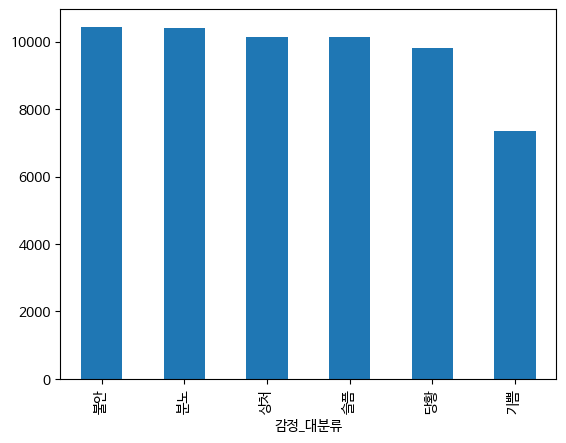

In [29]:
# label 개수 비교
conv_df['감정_대분류'].value_counts().plot(kind='bar')
print(conv_df.groupby('감정_대분류').size().reset_index(name='count'))

In [30]:
sent_df = pd.read_excel("/content/Data/한국어_단발성_대화_데이터셋.xlsx")
sent_df.head(10)

,Sentence,Emotion,Unnamed: 2,Unnamed: 3,Unnamed: 4,공포,5468
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,NaN,NaN,NaN,놀람,5898.0
1,그냥 내 느낌일뿐겠지?,공포,NaN,NaN,NaN,분노,5665.0
2,아직너무초기라서 그런거죠?,공포,NaN,NaN,NaN,슬픔,5267.0
3,유치원버스 사고 낫다던데,공포,NaN,NaN,NaN,중립,4830.0
4,근데 원래이런거맞나요,공포,NaN,NaN,NaN,행복,6037.0
5,남자친구가 떠날까봐요,공포,NaN,NaN,NaN,혐오,5429.0
6,이거 했는데 허리가 아플수도 있나요? ;;,공포,NaN,NaN,NaN,Total,38594.0
7,내가불안해서꾸는걸까..,공포,NaN,NaN,NaN,NaN,NaN
8,일주일도 안 남았당...ㅠㅠ,공포,NaN,NaN,NaN,NaN,NaN
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포,NaN,NaN,NaN,NaN,NaN


In [31]:
sent_df[['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4']].value_counts()

,,,count
Unnamed: 2,Unnamed: 3,Unnamed: 4,



Sentence와 Emotion 컬럼을 제외하고 삭제처리

In [32]:
sent_df = sent_df[['Sentence', 'Emotion']]
sent_df.head(10)

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
5,남자친구가 떠날까봐요,공포
6,이거 했는데 허리가 아플수도 있나요? ;;,공포
7,내가불안해서꾸는걸까..,공포
8,일주일도 안 남았당...ㅠㅠ,공포
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포


In [33]:
print(sent_df.shape)
print(sent_df.isnull().sum())

(38594, 2)
Sentence    0
Emotion     0
dtype: int64


  Emotion  count
0      공포   5468
1      놀람   5898
2      분노   5665
3      슬픔   5267
4      중립   4830
5      행복   6037
6      혐오   5429


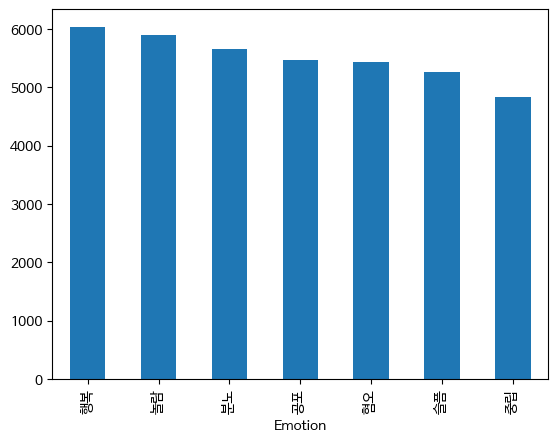

In [34]:
# label 개수 비교
sent_df['Emotion'].value_counts().plot(kind='bar')
print(sent_df.groupby('Emotion').size().reset_index(name='count'))

In [35]:
print(sent_df['Emotion'].value_counts())
print(sent_df['Emotion'].value_counts().sum())

Emotion
행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: count, dtype: int64
38594


1. 두 개 데이터 셋의 감정 레이블을 통일   
2. 데이터셋을 합치기
3. 레이블 카운트 다시 실행

In [36]:
print(conv_df['감정_대분류'].unique())
print(sent_df['Emotion'].unique())

['분노' '기쁨' '불안' '당황' '슬픔' '상처']
['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']


In [37]:
conv_df[conv_df['감정_대분류'] == '당황'].sample(10)

,Sentence,감정_대분류
36580,내가 개의치 않고 하던 발언이 친구에게 상처가 된 것 같아친구의 별명을 부르면 놀렸...,당황
38834,내가 벌 받는 것 같아.내가 신체장애가 있어 다른 사람들의 도움을 받아야 하는데 못...,당황
7274,직장 생활 육 개월 차인데 너무 힘들어. 사회생활이 이렇게 외로운 건가라는 생각도 ...,당황
33400,예전에 자주 보던 동창들 중에 혼자 된 친구들이 자꾸 생기네.이혼도 하고 사별도 하...,당황
45733,이번에 생물학과에서 디자인과로 편입을 했는데 이게 과연 잘한 선택인지 모르겠어.디자...,당황
6713,요즘 코로나가 다시 확산하는데도 관광지에는 사람들로 북적거려. 이 시기에 놀러 안 ...,당황
10847,어떤 친구들이 다른 친구의 돈을 뺏어 가. 정말 한심해.돈이 필요하면 자기가 벌어야...,당황
13192,나는 범인이 아닌데 아무도 내말을 안 믿어줘서 너무 충격적이야.어떻게 해야지 내 말...,당황
38712,나 지난달 말에 정년퇴직했네. 이제 어떻게 해야 할지 걱정되네.축하받을 일이 아니라...,당황
9588,오늘 중요한 업무가 있어서 어머니 병원을 못 갔어.맞아. 이런 적은 없었는데 죄송하...,당황


In [38]:
sent_df[sent_df['Emotion'] == '혐오'].sample(10)

,Sentence,Emotion
37248,잠이안와요..... ㅠㅠㅠㅠㅠㅠ,혐오
34293,나쁜놈들 북극 빙하 녹히려고 별 수를 다 쓰네.,혐오
36076,암컷으로만 구성된 집단에서 어떻게 새끼가 생김???,혐오
34193,역쉬 자기 자리 찾아 가는구나 너희는 딱9위 ㅋㅋㅋㅋㅋ,혐오
33206,결론은 보험사가 쓰레기네,혐오
37137,진짜 이 나라는 축제 안 열어본 티 팍팍 내네,혐오
38184,에라이 핸드폰 뜨거워져서 폭발이나 해라! 그래서 이 쓰레기를 태워버리기나 해라!,혐오
37323,나를 괴롭힌 놈들을 다 쳐죽여버린다.,혐오
35186,"촛불에 흔들리는 사법부도 원하지 않지만, 엄청난 실력의 변호인단을 이끌 수 있는 자...",혐오
33249,무기징역 사형 안하면이나라 국민 개돼지로 본다는거임,혐오


감성대화 말뭉치의 감정 label : 분노, 기쁨, 불안, 당황, 슬픔, 상처   
단발성 대화 세트의 감정 label : 공포, 놀람, 분노, 슬픔, 중립, 행복, 혐오    
두 데이터셋을 합치기 위해 감성대화 말뭉치의 label을 수정.

감정대화 말뭉치의 감정
- 분노 (유지)
- 기쁨 → 행복
- 불안 → 공포
- 상처 → 슬픔
- 당황 → 놀람

단발성 대화 세트의 감정
- 혐오 → 분노
- 중립 감정의 경우 데이터 균형성을 위해 일단 제거. 후에 활용 방안 다시 찾아볼것!

In [39]:
sent_df[sent_df['Emotion'] == '중립'].sample(10)

,Sentence,Emotion
23677,거품황제 ㅋㅋㅋㅋㅋ,중립
25421,누구를 위한 건지를 모르겠네,중립
26266,4대강 물무게가 지반을 침하시키고 있다.,중립
27056,아 연구대상감이다,중립
23137,그럼...고졸 아니라고 하고 중학교도 조사..하자.,중립
23673,소라넷이 없어져서 그런가?,중립
23689,제 네비는 순정네비라 스뫗트폰으로 튀맵보는게 더 정확하고 편하던데..,중립
25635,천국은 못간다고 전해라~~,중립
26844,감옥넣어서 똑같은대우받아봐라,중립
22711,때로는 무위의 삶이 필요하기도 하죠.,중립


In [40]:
# 기쁨 → 행복 / 불안 → 공포 / 상처 → 슬픔
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('기쁨', '행복')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('불안', '공포')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('상처', '슬픔')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('당황', '놀람')
sent_df['Emotion'] =sent_df['Emotion'].replace('혐오', '분노')
print(conv_df['감정_대분류'].unique())

['분노' '행복' '공포' '놀람' '슬픔']


In [41]:
# conv_df의 컬럼명 변경
conv_df = conv_df.rename(columns={'사람문장1': 'Sentence', '감정_대분류': 'Emotion'})
conv_df.sample(10)

,Sentence,Emotion
17042,친구들 사이에서 내가 노후 준비가 제일 안 되어 있는 것 같아.나도 나름대로 준비하...,공포
1268,은퇴 후에 재취업을 할 수 있을지 걱정돼.지금까지 쌓은 인맥과 경험도 은퇴 후에는 ...,공포
11198,우리 아들에 대해서 이젠 거의 포기상태야.자기 고집만 주장하고 완전 자기 멋대로야.,슬픔
29261,날 담당하던 의사선생님이 바뀌셨어.이전 선생님보다 더 신뢰가서 기분이 좋아.,행복
19795,교통사고로 인하여 심장박동수가 불안정하다는 아내의 상황을 의사에게 전해들은 뒤 내 ...,슬픔
16065,내가 걸린 암은 보험처리가 안 된다고 해서 치료비 전부를 부담해야 해. 너무 억울하...,슬픔
21280,높은 점수를 받아와 부모님께 자랑했는데 커닝한 것 아니냐며 나를 의심하셔서 너무 억...,슬픔
16864,영업직이라고 나를 막 대하는 고객이 종종 있어서 슬퍼.직업에 따라 사람을 대하는 방...,슬픔
1342,요즘 수험생 아들이 평온하고 성실하게 공부하고 있어서 기특할 따름이야.수험생인데도 ...,행복
9570,건강을 위해 운동이나 할까 해.뭐. 그냥 집에서 홈트부터 시작하려고.,행복


In [42]:
print(conv_df['Emotion'].value_counts())
print(conv_df['Emotion'].value_counts().sum())

Emotion
슬픔    20278
공포    10433
분노    10417
놀람     9804
행복     7339
Name: count, dtype: int64
58271


In [43]:
# 당황 감정을 제외하고 일단 합쳐보기
sent_df = sent_df[sent_df['Emotion'] != '중립']
sent_df = sent_df.reset_index(drop=True)
print(sent_df['Emotion'].unique())

['공포' '놀람' '분노' '슬픔' '행복']


In [44]:
# convDF와 sent_df 합치기
df = pd.concat([conv_df, sent_df])
df = df.reset_index(drop=True)
df.sample(10)

,Sentence,Emotion
30433,가족끼리 말다툼으로 많이 힘들어.용기내서 화해를 시도해야겠어. 그러면 좋은 결과 있...,슬픔
49969,열심히 살아왔는데 취업하기 너무 어려워서 서럽네.명문대 진학부터 앞만 보고 달려왔는...,슬픔
88759,이 선동하는 무리들을 보라 이 선동을ㅈ언급하기전에 이북에 애송이 적나라 하게 욕하고...,분노
17144,남편이 치매라는데 아직도 믿기지가 않아.어쩐지 요즘 들어 행동이 이상하다 했는데 설...,슬픔
80565,소집해제는 24살 2월이라 1년8개월정도남았습니다.....,슬픔
57556,공부를 매일 안 한 것을 후회해.한꺼번에 하려니까 너무 많아서 못하겠어.,슬픔
71751,자연을 파괴하는건 언제나 인간들..,분노
56492,자식들 키우느라 모아놓은 돈도 없고 나만 희생한 것 같아.자식들이 얼른 취직해서 용...,슬픔
31348,우리 반에 따돌림 당하는 친구가 있는데 모른척 하려니 미안해. 방관자가 되어버려서 ...,슬픔
17920,나이들 먹을 만큼 먹어놓고 아직도 싸우는 게 내가 자식들을 잘못 키웠나 봐.내가 자...,공포


In [45]:
print(df.shape)
print(df.isnull().sum())

(92035, 2)
Sentence    0
Emotion     0
dtype: int64


  Emotion  count
0      공포  15901
1      놀람  15702
2      분노  21511
3      슬픔  25545
4      행복  13376


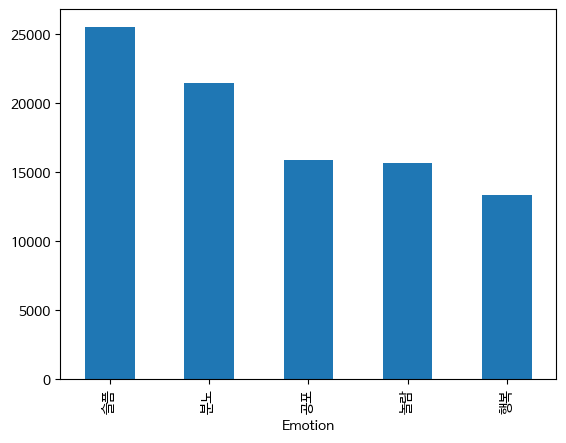

In [46]:
# label 개수 비교
df['Emotion'].value_counts().plot(kind='bar')
print(df.groupby('Emotion').size().reset_index(name='count'))

In [47]:
print(len(df[df['Emotion'] == '슬픔']) /len(df[df['Emotion'] == '행복']))

1.9097637559808613


Target Column label 별로 숫자 부여

In [48]:
# Emotion 컬럼 정수로 변환

emotion_dict = {'공포': 0, '놀람': 1, '분노': 2, '슬픔': 3, '행복': 4}
df['Emotion_dict'] = df['Emotion'].map(emotion_dict)
df.sample(10)

,Sentence,Emotion,Emotion_dict
884,어리게만 보았던 후배가 내게 고백했는데 당황스러워서 어떻게 해야 할지 모르겠네.심지...,놀람,1
71284,통화내역 조사해서 좌빨들과 사전공모 여부를 조사 해라 ㆍ,분노,2
10239,얼마 전에 버스에서 내리다가 다쳐서 발등에 금이 갔어.부어오르길래 한의원에 가서 치...,분노,2
16813,나는 가장이라는 이유로 지금까지 모든 경제적인 것에 책임을 져 와서 지금 지쳤어.회...,분노,2
83607,문의사항이나 제보는 아래로 연락주시면 감사하겠습니다.,행복,4
79296,이대론 꿈도 희망도 없어ㅜㅜ,슬픔,3
53805,남편이 자신이 유부남인 걸 자각 안 하고 술 마시면서 밤늦게 들어오니까 너무 화가 ...,분노,2
81040,TV에서 자주 뵙는데 멋지십니다,행복,4
3425,드디어 승진에 필요한 자격증을 따서 마음이 한결 편안해졌어.거의 삼 년 동안 주말을...,행복,4
5281,국가에서 지원해 주는 여러 노인복지가 많아서 다행이야.그 덕분에 수입이 없어도 그럭...,행복,4


In [49]:
# 합친 데이터 저장
df.to_csv('/content/Data/concated_df.csv', index=False)

In [50]:
# 확인
df = pd.read_csv('/content/Data/concated_df.csv')
df.sample(10)

,Sentence,Emotion,Emotion_dict
30514,오늘 집에서 내 분노를 가족에게 표출했어.고등학교 진학을 내가 원하는 곳으로 못가게...,분노,2
60452,혈압약이나 감기약 요런약들은 만지는데 이게 만지는것만으로도 태아에게 지장있는가요..,공포,0
85230,생일 축하합니다..,행복,4
86342,진정!! 멋지십니다!!!,행복,4
35971,공부는 도대체 왜 해야하는거지?나는 성실히 했는데 성적이 바닥이야. 진로도 불투명하...,분노,2
68867,여러분 약이 이렇게 무서운겁니다. ㅋㅋㅋ,놀람,1
2060,노인이 되니 점점 다른 사람들의 눈치를 보게 되네.젊은 세대들이 더 우수하다는 생각...,놀람,1
67848,연봉 수준이 진짜 천문학적이딘,놀람,1
49763,병원에 가 보니 당뇨가 심하대. 운동을 하라는데 도저히 흥미가 안 생겨.당뇨로 가뜩...,공포,0
77349,싸이트에는 연령-무 라고 기재해놓고 전화 했더니 죄송합니다.,슬픔,3


# Data Preprocessing

In [51]:
# 데이터 불러오기
df = pd.read_csv('/content/Data/concated_df.csv')
df.sample(10)

,Sentence,Emotion,Emotion_dict
41378,장기 두던 영감들이 이제 하나 둘씩 먼저 가버리네. 젊을 때부터 동고동락하던 사이였...,분노,2
64700,권지용 없으니까 키가 작아보이진 않네,놀람,1
61135,혹시 다른 분들도 이러신 적 있으신가요?ㅠㅠ,공포,0
2694,다음 달에 출산을 앞두고 있는데 너무 떨리면서도 무서워.응. 남편도 매일같이 내 배...,공포,0
69781,이참에 삼성이재용 뜨거운 맛을보여줘야한다,분노,2
6765,남자친구랑 제주도로 휴가 가기로 했어.그렇지. 여유롭게 푹 쉬다가 오려고.예약도 다...,행복,4
85216,벌써 7년이 다 되어가네용!,행복,4
42709,같이 살아도 이렇게 외롭고 고독한데 남편이 있으면 뭐 해. 내 팔자도 참.전에는 혼...,분노,2
25538,나는 순이 할머니보다 돈도 없고 자식도 없네.나를 돌봐줄 자식이 없는 것이 가장 괴...,슬픔,3
43884,관절염 때문에 더 일을 나가지 못할 것 같아. 너무 속상해.오래 서 있어야 하는데 ...,슬픔,3


In [52]:
# 모델링에 사용할 Sentence, Emotion_dict 컬럼만 사용
df = df[['Sentence', 'Emotion_dict']]
df.sample(10)

,Sentence,Emotion_dict
27930,남자친구를 사랑하지도 않으면서 돈 때문에 결혼하기로 결심했어.남자친구는 나를 많이 ...,1
12068,이번에도 취업 서류 전형에서 떨어졌어.뭐가 문제인지 모르겠어. 내가 그렇게 부족한 ...,3
25728,지하철을 타면 나에게 자리를 양보해주는 젊은이들이 참 고마워.고마우면서도 아직 크게...,4
8039,그렇게 잘해줬는데 왜 내 마음을 몰라주는지 모르겠어.지금까지 내가 공들인 시간을 생...,2
22825,집사람이랑 지출 확인을 했는데 내 월급 보다 더 많이 쓰고 있었더라고. 속상하네.내...,3
28839,여자친구랑 싸웠어.나는 조금 더 연애하고 느긋하게 결혼하고 싶은데 여자친구는 아닌가...,4
62930,상담 원합니다 일 문제입니다,0
21104,나는 상사가 부당한 일을 시켜도 어쩔 수 없이 따라야 해.부당하다고 생각되는데도 어...,0
54235,요즘 다리에 힘이 잘 안 들어가서 힘들어.응. 종종 이러다가 영영 못 걷는 것은 아...,0
17454,몇 년 동안 준비했던 공무원 필기시험에 합격했어. 너무 기뻐부모님에게 이 사실을 당...,4


KoBERT는 text, label 형식으로 입력해야하기 때문에 df 데이터 프레임의 Sentence와 Emotion_dict를 묶은 데이터셋을 생성

In [53]:
# text, label로 묶인 data list 생성
data_list = []
for q, label in zip(df['Sentence'], df['Emotion_dict'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

## Split train & test data set

In [54]:
# 데이터 분리 (Train & Test)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_list, test_size=0.2, random_state=2024, stratify=df['Emotion_dict'])
print(len(train_df))
print(len(test_df))

73628
18407


## Tokenization
KoBERT 오픈소스 내 예제 코드 및 블로그 참조

In [55]:
#  BERTDataset : 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수.
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [56]:
# parameter setting
max_len = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [57]:
# tokenizer 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [58]:
# TypeError: BERTSentenceTransform.__init__() got an unexpected keyword argument 'vocab' 오류 해결 (KoBERT finetuning 오픈소스 예시 코드)
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [59]:
# BERTDataset : 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수.
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [60]:
# BERTDataset에 split된 데이터 입력, input 형식에 맞도록 변환하기
# from kobert import get_tokenizer

# tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(train_df, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test_df, 0, 1, tokenizer, vocab, max_len, True, False)

In [61]:
# 위에서 변환한 데이터를 torch 형식으로 변환
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

# KoBERT 모델 구현

In [62]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 5,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [63]:
# BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [64]:
# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


In [65]:
# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# Model Training

In [66]:
train_history = []
test_history = []
loss_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape, out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # train_history.append(train_acc / (batch_id+1))

    # .eval() : nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    # 즉, model이 Dropout이나 BatNorm2d를 사용하는 경우, train 시에는 사용하지만 evaluation을 할 때에는 사용하지 않도록 설정해주는 함수
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.6247870922088623 train acc 0.21875
epoch 1 batch id 201 loss 1.3342705965042114 train acc 0.34320584577114427
epoch 1 batch id 401 loss 1.1300289630889893 train acc 0.4688668952618454
epoch 1 batch id 601 loss 0.8735904693603516 train acc 0.53369384359401
epoch 1 batch id 801 loss 0.6872360110282898 train acc 0.5690543071161048
epoch 1 batch id 1001 loss 0.8255304098129272 train acc 0.5912056693306693
epoch 1 train acc 0.6046527863969219


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 1 test acc 0.6956894920762109


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8632749915122986 train acc 0.65625
epoch 2 batch id 201 loss 0.8595668077468872 train acc 0.6999378109452736
epoch 2 batch id 401 loss 0.9296661019325256 train acc 0.7034367206982544
epoch 2 batch id 601 loss 0.6654741168022156 train acc 0.715292221297837
epoch 2 batch id 801 loss 0.4545287489891052 train acc 0.722397784019975
epoch 2 batch id 1001 loss 0.7219282388687134 train acc 0.7279127122877123
epoch 2 train acc 0.7319547443217078


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 2 test acc 0.7014751379985755


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7104974985122681 train acc 0.765625
epoch 3 batch id 201 loss 0.7075579166412354 train acc 0.7631374378109452
epoch 3 batch id 401 loss 0.7318992018699646 train acc 0.7706514962593516
epoch 3 batch id 601 loss 0.41030701994895935 train acc 0.7803400582362728
epoch 3 batch id 801 loss 0.24732057750225067 train acc 0.7855415106117354
epoch 3 batch id 1001 loss 0.4972842335700989 train acc 0.7898195554445554
epoch 3 train acc 0.7934269113814074


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 3 test acc 0.7208088497150997


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6424365043640137 train acc 0.765625
epoch 4 batch id 201 loss 0.6750463247299194 train acc 0.8197294776119403
epoch 4 batch id 401 loss 0.56640625 train acc 0.828514650872818
epoch 4 batch id 601 loss 0.2762102782726288 train acc 0.8375103993344426
epoch 4 batch id 801 loss 0.20345108211040497 train acc 0.8420529026217228
epoch 4 batch id 1001 loss 0.37828174233436584 train acc 0.8457792207792207
epoch 4 train acc 0.8482821614744943


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 4 test acc 0.7198281138710826


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5417117476463318 train acc 0.78125
epoch 5 batch id 201 loss 0.5339943766593933 train acc 0.8669931592039801
epoch 5 batch id 401 loss 0.49984505772590637 train acc 0.8710255610972568
epoch 5 batch id 601 loss 0.18314765393733978 train acc 0.8774178452579035
epoch 5 batch id 801 loss 0.16363629698753357 train acc 0.8788623595505618
epoch 5 batch id 1001 loss 0.3167785704135895 train acc 0.8799637862137862
epoch 5 train acc 0.8808295581481941


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 5 test acc 0.7180920027599715


# Model Test

In [67]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("행복이")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

'공포': 0, '놀람': 1, '분노': 2, '슬픔': 3, '행복': 4

In [1]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 나오늘 밥먹고 잇어


NameError: name 'predict' is not defined